In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import glob
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
default_columns = ('bm_name', 'NumCPU', 'manual_time')

columns = {'BM_RooFit_BinnedMultiProcGradient': ('bm_name', 'bins', 'NumCPU', 'manual_time'),
           'BM_RooFit_1DUnbinnedGaussianMultiProcessGradMinimizer': default_columns,
           'BM_RooFit_NDUnbinnedGaussianMultiProcessGradMinimizer': ('bm_name', 'NumCPU', 'dims', 'manual_time'),
           'BM_RooFit_MP_GradMinimizer_workspace_file': default_columns
          }

In [58]:
def subplots(total, wrap=None, **kwargs):
    """
    Make `total` subplots, wrapped horizontally by `wrap` columns.
    `kwargs` passed to `plt.subplots`.
    """
    if wrap is not None:
        cols = min(total, wrap)
        rows = 1 + (total - 1)//wrap
    else:
        cols = total
        rows = 1
    fig, ax = plt.subplots(rows, cols, **kwargs)
    return fig, ax

In [59]:
def load_result(it=-1, **kwargs):
    json_files = sorted(glob.glob('/Users/pbos/projects/apcocsm/roofit-dev/rootbench/cmake-build-debug/root/roofit/roofit/RoofitMultiproc_*.json'))
    return load_result_file(json_files[it], **kwargs)

def load_result_file(fn, show_dfs=False, figscale=6):
    dfs = {}
    with open(fn) as fh:
        raw = json.load(fh)
        print(raw['context'])
        benchmarks = defaultdict(list)
        for bm in raw['benchmarks']:
            name = bm['name'].split('/')[0]
            benchmarks[name].append(bm)
        
#         fig, ax = plt.subplots(1 + (1+len(benchmarks))//3, len(benchmarks),
#                                figsize=(len(benchmarks)*1.1*figscale, figscale),
#                                squeeze=False)
        fig, ax = subplots(len(benchmarks), wrap=3,
                           figsize=(len(benchmarks)*1.1*figscale, figscale),
                           squeeze=False)
        ax = ax.flatten()

        for ix, (name, bmlist) in enumerate(benchmarks.items()):
            dfs[name] = pd.DataFrame(bmlist)
            df_names = pd.DataFrame(dfs[name].name.str.slice(start=len("BM_RooFit_")).str.split('/').values.tolist(), columns=columns[name])
            dfs[name] = dfs[name].join(df_names).drop(['name', 'manual_time', 'iterations'], axis=1)
            if show_dfs:
                display(dfs[name])
            if name == 'BM_RooFit_BinnedMultiProcGradient':
                sns.pointplot(data=dfs[name], x='NumCPU', y='real_time', hue='bins', ax=ax[ix])
            elif name == 'BM_RooFit_NDUnbinnedGaussianMultiProcessGradMinimizer':
                sns.pointplot(data=dfs[name], x='NumCPU', y='real_time', hue='dims', ax=ax[ix])
            else:
                sns.pointplot(data=dfs[name], x='NumCPU', y='real_time', ax=ax[ix])
            ax[ix].set_title(name)
    return dfs

{'date': '2018-12-19 10:33:06', 'num_cpus': 4, 'mhz_per_cpu': 2900, 'cpu_scaling_enabled': False, 'library_build_type': 'debug'}


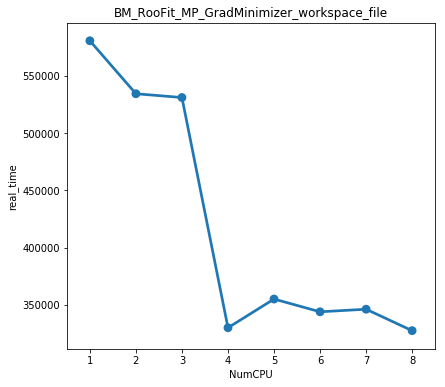

In [60]:
_ = load_result()

{'date': '2018-12-18 13:08:29', 'num_cpus': 80, 'mhz_per_cpu': 2400, 'cpu_scaling_enabled': False, 'library_build_type': 'release'}


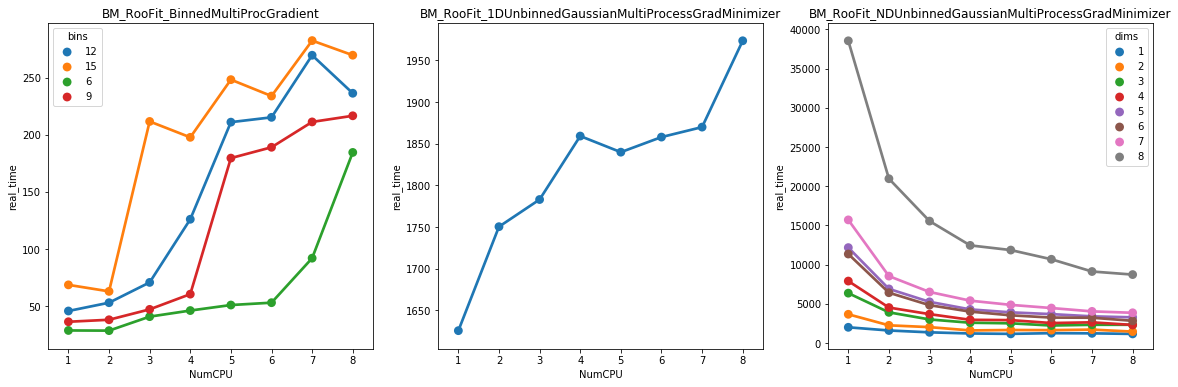

In [61]:
dfs = load_result_file('stbc-i5_marks/RoofitMultiproc_1545134908.json')

In [57]:
dfs.keys()

dict_keys(['BM_RooFit_BinnedMultiProcGradient', 'BM_RooFit_1DUnbinnedGaussianMultiProcessGradMinimizer', 'BM_RooFit_NDUnbinnedGaussianMultiProcessGradMinimizer'])

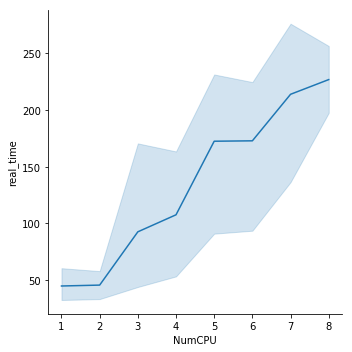

In [89]:
# dfs['BM_RooFit_BinnedMultiProcGradient'].groupby('bins').plot(x='NumCPU')
sns.relplot(data=dfs['BM_RooFit_BinnedMultiProcGradient'], x='NumCPU', y='real_time', kind='line')#, hue='bins')

In [88]:
dfs['BM_RooFit_BinnedMultiProcGradient']

,cpu_time,real_time,time_unit,bm_name,bins,NumCPU
0,19.954375,28.703853,ms,BinnedMultiProcGradient,6,1
1,18.704871,28.551176,ms,BinnedMultiProcGradient,6,2
2,29.109639,40.801207,ms,BinnedMultiProcGradient,6,3
3,25.201844,46.130108,ms,BinnedMultiProcGradient,6,4
4,31.216566,50.957357,ms,BinnedMultiProcGradient,6,5
5,32.801346,53.014122,ms,BinnedMultiProcGradient,6,6
6,39.050057,91.987230,ms,BinnedMultiProcGradient,6,7
7,40.650364,184.561090,ms,BinnedMultiProcGradient,6,8
8,23.201177,36.320553,ms,BinnedMultiProcGradient,9,1
9,24.060109,38.064850,ms,BinnedMultiProcGradient,9,2
